In [35]:
import glob
import pandas as pd
import numpy as np
import re
import itertools
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as img

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
# Data input (making dataframe of image file paths and respective categories)
data_path = "/lungcancer/lung_image_sets/**/*.jpeg"
path_list = glob.glob(data_path, recursive= True)
status_list = []
for i in path_list:
    if re.search(r'lungaca',i):
        status_list.append('lung adenocarcinoma')
    elif re.search(r'lungn',i):
        status_list.append('lung benign tissue')
    else:
        status_list.append('lung squamous cell carcinoma')
lcdf = pd.DataFrame(list(zip(path_list, status_list)), columns=['Path', 'Status'])
np.random.shuffle(lcdf.values)

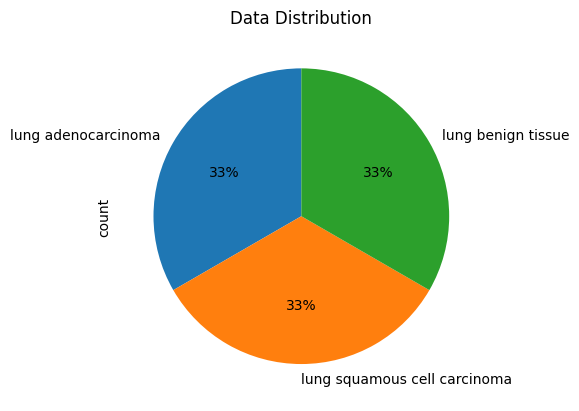

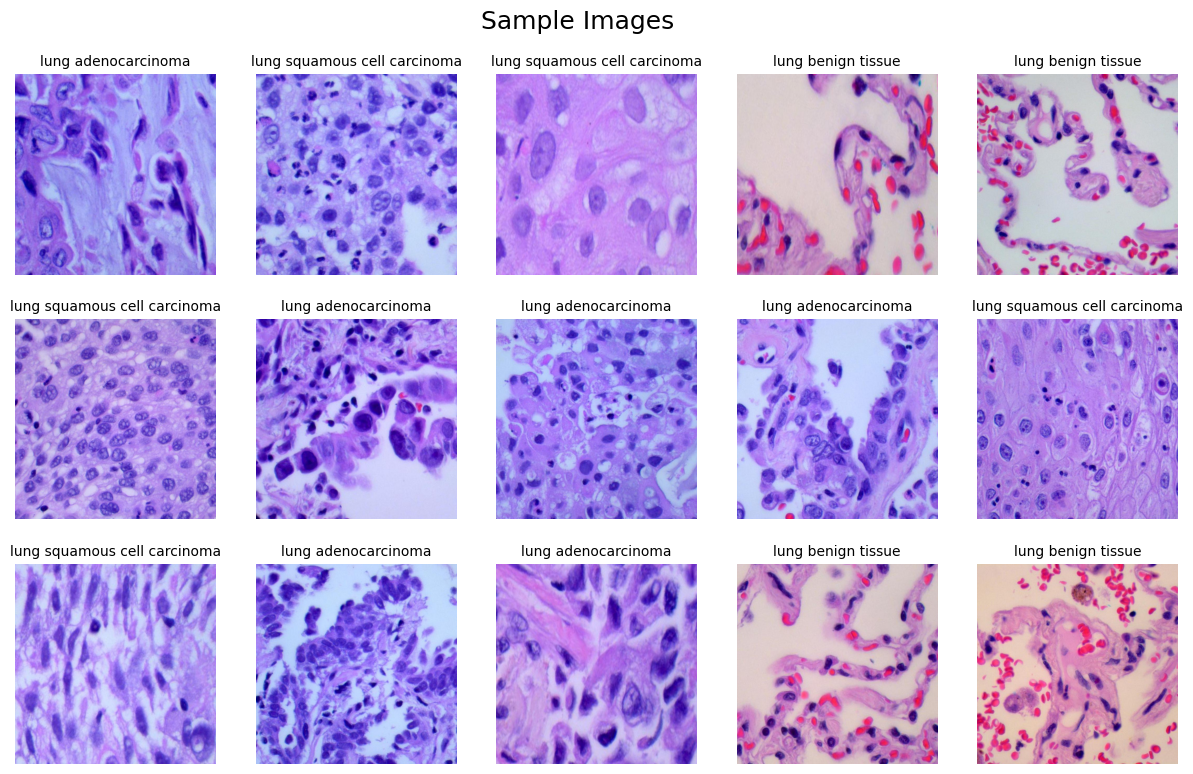

In [5]:
# Exploring data
ax = lcdf.Status.value_counts().plot(kind='pie', autopct='%1.0f%%', startangle = 90)
ax.set_title('Data Distribution')
fig = plt.figure(figsize=(15, 9))
fig.suptitle('Sample Images', fontsize=18, y=0.95)
for i, row in lcdf.iloc[:15].iterrows():
    plt.subplot(3,5, i+1)
    image = img.imread(row['Path'])
    plt.title(row['Status'], fontsize=10)
    plt.axis('off')
    plt.imshow(image)

In [6]:
# Splitting data
train_set, combine_set = train_test_split(lcdf, train_size=0.8, random_state=16)
validation_set, test_set = train_test_split(combine_set, train_size=0.5, random_state=16)

In [24]:
# Preprocessing data (Images from input dataset are already augmented)
datagen = ImageDataGenerator()
tr_set = datagen.flow_from_dataframe(train_set, x_col='Path', y_col='Status', target_size=(224,224), 
                                    class_mode='categorical', batch_size=32, shuffle = True, seed=16, color_mode='rgb')
vldn_set = datagen.flow_from_dataframe(validation_set, x_col='Path', y_col='Status', target_size=(224,224),
                                      class_mode='categorical', batch_size=32, shuffle = False, seed=16,color_mode='rgb')
ts_set = datagen.flow_from_dataframe(test_set, x_col='Path', y_col='Status', target_size=(224,224),
                                    class_mode='categorical', batch_size=32, shuffle = False, seed=16,color_mode='rgb')

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [74]:
# Building model
cnn_model = Sequential([Conv2D(filters=128, kernel_size=(5,5), padding='valid', input_shape=(224,224,3)), 
                        Activation('relu'), MaxPool2D(pool_size=(2,2)), 
                        BatchNormalization(),
                        Conv2D(filters=64, kernel_size=(3,3), padding='valid'), 
                        Activation('relu'),
                        MaxPool2D(pool_size=(2,2)),
                        BatchNormalization(),
                        Conv2D(filters=32, kernel_size=(3,3), padding='valid'), 
                        Activation('relu'), 
                        MaxPool2D(pool_size=(2,2)), 
                        BatchNormalization(),
                        Flatten(),
                        Dense(units=256, activation='relu'),
                        Dropout(0.5),
                        Dense(units=3, activation='softmax')])
cnn_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)              │ (None, 220, 220, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 220, 220, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 110, 110, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 110, 110, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 108, 108, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 108, 108, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,641,699 (21.52 MB)

 Trainable params: 5,641,251 (21.52 MB)

 Non-trainable params: 448 (1.75 KB)

In [76]:
# Adding checkpoint and callback
checkpoint = ModelCheckpoint("/lungcancer/model_a.keras", monitor='val_accuracy', save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=1, mode='max')

In [77]:
# Compiling model
cnn_model.compile(Adam(learning_rate= 0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [78]:
# Training model
history = cnn_model.fit(tr_set,validation_data=vldn_set,epochs=60,callbacks=[checkpoint,early])

Epoch 1/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 1303s 3s/step - accuracy: 0.8267 - loss: 1.2958 - val_accuracy: 0.5007 - val_loss: 3.5583
Epoch 2/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 1238s 3s/step - accuracy: 0.8750 - loss: 0.5471 - val_accuracy: 0.6380 - val_loss: 1.0816
Epoch 3/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 1220s 3s/step - accuracy: 0.8877 - loss: 0.3972 - val_accuracy: 0.8953 - val_loss: 0.2805
Epoch 4/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 1220s 3s/step - accuracy: 0.9052 - loss: 0.2651 - val_accuracy: 0.8660 - val_loss: 0.4163
Epoch 5/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 1219s 3s/step - accuracy: 0.9170 - loss: 0.2501 - val_accuracy: 0.8473 - val_loss: 0.4202
Epoch 6/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 1217s 3s/step - accuracy: 0.9094 - loss: 0.2489 - val_accuracy: 0.7753 - val_loss: 0.7546
Epoch 7/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 1219s 3s/step - accuracy: 0.9163 - loss: 0.2211 - val_accuracy: 0.9440 - val_loss: 0.1422
Epoch 8/60
375/375 ━━━━━━━━━━━━━━━━━━━━ 1215s 3s/step - accuracy: 0.9396 - loss: 0.1700 - 

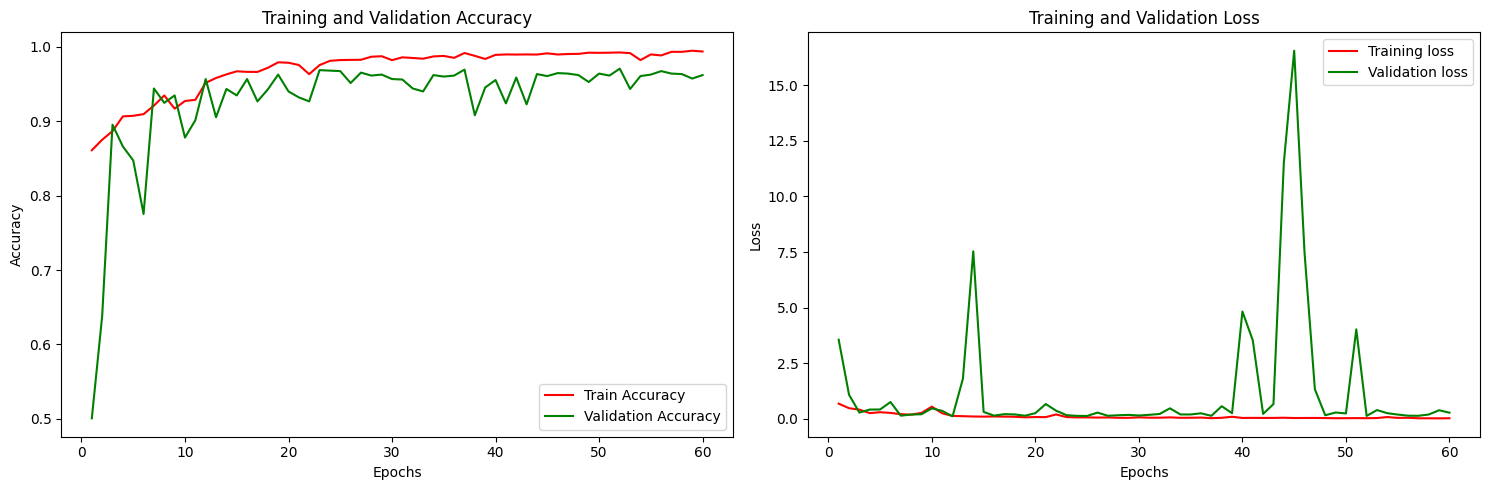

In [92]:
# Plotting history of training
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1,61)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'r', label= 'Train Accuracy')
plt.plot(epochs, val_accuracy, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# loading best saved model
loaded_model = load_model("/lungcancer/model_a.keras", compile=False)
loaded_model.compile(Adam(learning_rate= 0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [32]:
# Model evaluation
train_score = loaded_model.evaluate(tr_set ,verbose = 1)
valid_score = loaded_model.evaluate(vldn_set ,verbose = 1)
test_score = loaded_model.evaluate(ts_set ,verbose = 1)

375/375 ━━━━━━━━━━━━━━━━━━━━ 334s 891ms/step - accuracy: 0.9933 - loss: 0.0381
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 756ms/step - accuracy: 0.9962 - loss: 0.0246
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9934 - loss: 0.0338


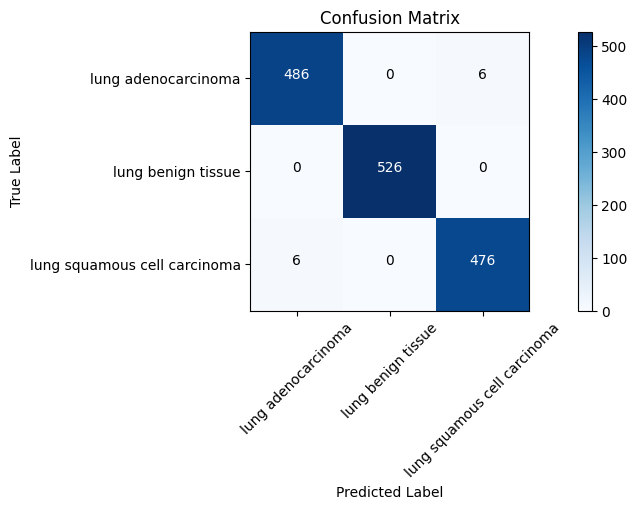

In [39]:
# Predicting and plotting confusion matrix
pred = loaded_model.predict(ts_set)
y_pred = np.argmax(pred, axis=1)
dict = ts_set.class_indices
classes = list(dict.keys())
cm = confusion_matrix(ts_set.classes, y_pred)
plt.figure(figsize= (10, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [38]:
# Classification report
print(classification_report(ts_set.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

         lung adenocarcinoma       0.99      0.99      0.99       492
          lung benign tissue       1.00      1.00      1.00       526
lung squamous cell carcinoma       0.99      0.99      0.99       482

                    accuracy                           0.99      1500
                   macro avg       0.99      0.99      0.99      1500
                weighted avg       0.99      0.99      0.99      1500

